<a href="https://colab.research.google.com/github/Sciform/sciform-hwz-ai-in-controlling/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=61e4d481452a0dfd0701c910803577946a75cc60b453f35d3d454efd04d40332
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [3]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [4]:
#pyoff.init_notebook_mode()

In [5]:
from google.colab import files
retail_data_file = files.upload()

Saving OnlineRetail.csv to OnlineRetail.csv


In [150]:
# tx_data = pd.read_csv('data.csv')
import io
tx_data = pd.read_csv(io.BytesIO(retail_data_file['OnlineRetail.csv']), encoding = "ISO-8859-1")

In [151]:
tx_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [152]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [153]:
tx_data['InvoiceDate'].describe(datetime_is_numeric=True)

count                           541909
mean     2011-07-04 13:34:57.156386048
min                2010-12-01 08:26:00
25%                2011-03-28 11:34:00
50%                2011-07-19 17:17:00
75%                2011-10-19 11:27:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [154]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [155]:
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']

In [156]:
tx_user.head(10)

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0
5,15291.0
6,14688.0
7,17809.0
8,15311.0
9,14527.0


# Recency

To calculate recency, we have to determine the most recent purchase date of each customer and comute how many days they are inactive. With the number of inactive days for each customer, we apply K-means* clustering to assign customers a recency score.

In [157]:
# get latest purchase date for each customer
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()

In [158]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [159]:
tx_max_purchase.head(10)

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00
5,12821.0,2011-05-09 15:51:00
6,12822.0,2011-09-30 10:04:00
7,12823.0,2011-09-26 07:35:00
8,12824.0,2011-10-11 12:49:00
9,12826.0,2011-12-07 10:25:00


In [160]:
# compute column recency = overall most recent invoice date - most recent invoice date per user in [days]
# recency is the number of inactive days for each customers
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [161]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [162]:
tx_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [163]:
tx_user.Recency.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

In [164]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

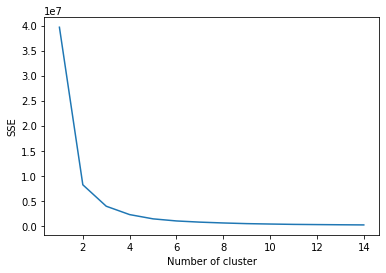

In [165]:
from sklearn.cluster import KMeans


sse={}
tx_recency = tx_user[['Recency']]
num_max_clusters = 15
for k in range(1, num_max_clusters):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [166]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [167]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2027.0,18.695609,14.335825,0.0,7.00,16.0,29.0,50.0
1,568.0,190.179577,32.227303,137.0,163.75,188.0,217.0,249.0
2,905.0,81.832044,23.706084,51.0,63.00,75.0,98.0,136.0
3,450.0,307.997778,39.742349,250.0,273.00,303.0,351.0,373.0


In [168]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [169]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [170]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,450.0,307.997778,39.742349,250.0,273.00,303.0,351.0,373.0
1,568.0,190.179577,32.227303,137.0,163.75,188.0,217.0,249.0
2,905.0,81.832044,23.706084,51.0,63.00,75.0,98.0,136.0
3,2027.0,18.695609,14.335825,0.0,7.00,16.0,29.0,50.0


# Frequency

In [171]:
# count the number of invoices for each customer

tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()

In [172]:
tx_frequency.columns = ['CustomerID','Frequency']

In [173]:
tx_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [174]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [175]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


In [176]:
tx_user.Frequency.describe()

count    3950.000000
mean       91.614684
std       220.557389
min         1.000000
25%        17.000000
50%        41.000000
75%       101.000000
max      7983.000000
Name: Frequency, dtype: float64

In [177]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [178]:
import warnings
warnings.filterwarnings("ignore")

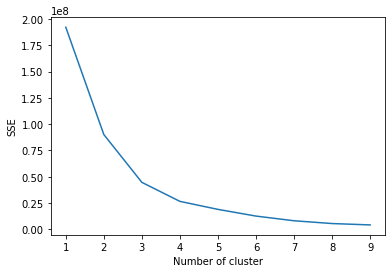

In [179]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [180]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [181]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
1,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0


In [182]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [183]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


# Monetary Value / Revenue

In [184]:
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']

In [185]:
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [186]:
tx_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [187]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61
...,...,...,...,...,...,...
3945,14056.0,0,3,1128,2,8124.40
3946,14456.0,4,3,977,2,3047.63
3947,12748.0,0,3,4642,3,29072.10
3948,17841.0,1,3,7983,3,40340.78


In [188]:
tx_user.Revenue.describe()

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: Revenue, dtype: float64

In [189]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [190]:
import warnings
warnings.filterwarnings("ignore")

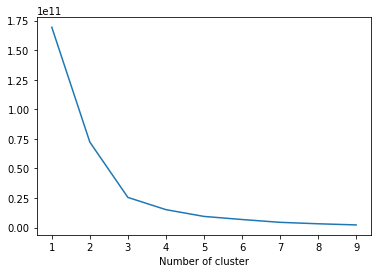

In [192]:
sse={}

tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [194]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [195]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [196]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


# Overall Segmentation

In [197]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1


In [198]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [199]:
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5
...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8
3946,17841.0,1,3,7983,3,40340.78,2,8
3947,14096.0,3,3,5128,3,57120.91,2,8
3948,17450.0,7,3,351,1,187482.17,3,7


In [200]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,308.233184,22.051570,301.159417
1,190.976868,32.215302,486.966336
2,83.302405,46.156930,852.831927
3,22.023975,67.381073,1083.572121
4,14.889262,271.929530,3595.252785
5,9.932886,372.442953,9109.370000
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


In [201]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0     446
1     562
2     873
3    1585
4     298
5     149
6      27
7       7
8       3
Name: Recency, dtype: int64

In [209]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [210]:
tx_user['Segment'].value_counts()

Mid-Value     1883
Low-Value     1881
High-Value     186
Name: Segment, dtype: int64

In [211]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [212]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [213]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Overall clustering with 3 features

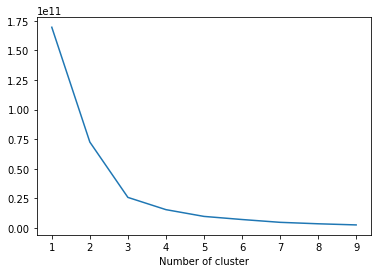

In [217]:
sse={}
tx_features = tx_user[['Recency', 'Frequency', 'Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_features)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


In [253]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(tx_features)
tx_user['OverallCluster'] = kmeans.predict(tx_features)
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,OverallCluster
0,17850.0,301,0,312,1,5288.63,2,2,Low-Value,0
1,14688.0,7,3,359,1,5107.38,2,5,High-Value,0
2,13767.0,1,3,399,1,16945.71,2,5,High-Value,6
3,15513.0,30,3,314,1,14520.08,2,5,High-Value,6
4,14849.0,21,3,392,1,7904.28,2,5,High-Value,0
...,...,...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,3,8,High-Value,3
3946,17841.0,1,3,7983,3,40340.78,3,8,High-Value,3
3947,14096.0,3,3,5128,3,57120.91,3,8,High-Value,4
3948,17450.0,7,3,351,1,187482.17,1,7,High-Value,2


In [254]:
tx_user['OverallCluster'].value_counts()

1    2943
7     743
0     182
6      53
3      15
4      11
8       1
2       1
5       1
Name: OverallCluster, dtype: int64

In [255]:
tx_result = tx_user.groupby('OverallCluster')['Recency','Frequency','Revenue'].mean()
tx_result

,Recency,Frequency,Revenue
OverallCluster,,,
0,23.285714,334.434066,6317.847473
1,110.781515,42.299694,512.992152
2,7.000000,351.000000,187482.170000
3,5.666667,1127.733333,30748.766000
4,6.272727,1225.636364,55776.831818
5,0.000000,433.000000,256438.490000
6,10.169811,383.547170,12650.380566
7,37.153432,166.806191,2464.328938
8,2.000000,1076.000000,88125.380000


In [257]:
tx_result.sort_values(by=['Recency', 'Frequency', 'Revenue'], ascending=False)

,Recency,Frequency,Revenue
OverallCluster,,,
1,110.781515,42.299694,512.992152
7,37.153432,166.806191,2464.328938
0,23.285714,334.434066,6317.847473
6,10.169811,383.547170,12650.380566
2,7.000000,351.000000,187482.170000
4,6.272727,1225.636364,55776.831818
3,5.666667,1127.733333,30748.766000
8,2.000000,1076.000000,88125.380000
5,0.000000,433.000000,256438.490000


In [258]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,308.233184,22.051570,301.159417
1,190.976868,32.215302,486.966336
2,83.302405,46.156930,852.831927
3,22.023975,67.381073,1083.572121
4,14.889262,271.929530,3595.252785
5,9.932886,372.442953,9109.370000
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000
